In [2]:
import pandas as pd
import numpy as np
from wmb import brain, cemba, mm10
import pathlib
import seaborn as sns
from matplotlib import pyplot as plt
from collections import defaultdict
from ALLCools.mcds import MCDS
import dask
import collections
from scipy.stats import zscore
import joblib

In [3]:
qval_cutoff =0.01
var_dim = 'geneslop2k-vm23'
chrom_to_remove = ['chrX', 'chrY', 'chrM', 'chrL']
mc_type = 'CHN'

group_name = 'DissectionRegion_MOB-AON-PIR'


In [4]:
# Parameters
chrom_to_remove = ["chrX", "chrY", "chrM", "chrL"]
cpu = 40
group_name = "DissectionRegion_Slice12-FGHJ"
mc_type = "CHN"
mem_gb = 15
qval_cutoff = 0.01
var_dim = "geneslop2k-vm23"


In [5]:
var, region_axis = group_name.split('_')

## select use dmgs

In [6]:
cells = pd.read_csv(f'/home/qzeng_salk_edu/project/cemba/230223_spatial/_prepare/{region_axis}.mc_cells.txt', 
                    index_col=0, header=None).index
cells.name = 'cell'
cells.size

8579

In [7]:
cef_score = pd.read_csv(f'{region_axis}_{var}.CEF_score.csv', index_col = 0)
cef_vals = pd.read_csv(f'{region_axis}_{var}.CEF_vals.csv', index_col = 0)

In [8]:
# filter genes with all na score
from pandas.errors import EmptyDataError 
use_genes_by_score = cef_score.isna().sum(axis= 1)[cef_score.isna().sum(axis= 1) != cef_score.shape[1]].index

try:
    use_genes_by_anova = [mm10.gene_id_to_name(gene_id) for gene_id in list(pd.read_csv('filtered_genes.txt', header = None)[0])]
    use_genes = list(set(use_genes_by_score) & set(use_genes_by_anova))
except EmptyDataError:
    use_genes = list(set(use_genes_by_score)) 

In [9]:
len(use_genes)

18549

In [10]:
# select cef dataframe
cef_score = cef_score.loc[use_genes]
cef_vals = cef_vals.loc[use_genes]

cef_score = cef_score[~cef_score.index.duplicated(keep='first')]
cef_vals = cef_vals[~cef_vals.index.duplicated(keep='first')]

cef_vals = cef_vals.fillna(1)

In [11]:
# for each subregion, select genes with the highest score and qvals < 0.05
subregion_dmg = cef_score.idxmax(axis = 1).to_dict()
subregion_dmgs = defaultdict(list)
for gene, subregion in subregion_dmg.items():
    try:
        if cef_vals.loc[gene,subregion] < qval_cutoff:
            subregion_dmgs[subregion].append(gene)
    except KeyError:
        continue
        
        

In [12]:
# balance gene number
gene_num = {}
for _region, dmg_list in  subregion_dmgs.items():
    gene_num[_region] = len(dmg_list)

target_number = np.sqrt(pd.Series(gene_num)) * 20
target_number = (pd.DataFrame([pd.Series(gene_num), target_number]).T.min(axis =1)-1).astype(int)

In [13]:
balanced_subregion_dmgs = {}
for _region in list(gene_num.keys()):
    top_gene_number = target_number[f'{_region}']
    top_genes = cef_score.loc[subregion_dmgs[_region]][_region].sort_values(ascending = False)[:top_gene_number].index.tolist()
    balanced_subregion_dmgs[_region] = top_genes

In [14]:
all_gene_ids = pd.read_csv(f'./{region_axis}.mc_genes.txt', index_col=0, header=None).index
use_gene_ids = [mm10.gene_name_to_id(gene_name) for gene_name in use_genes]
genes  = list(set(all_gene_ids) & set(use_gene_ids))
genes = pd.Index(genes)
genes.name = 'genes'

## get mc_frac df

In [15]:
mcds = MCDS.open(cemba.CEMBA_SNMC_MCDS_PATH, var_dim=var_dim, use_obs=cells )
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    mcds = mcds.sel({"geneslop2k-vm23": genes, "mc_type": mc_type })
mcds

<xarray.MCDS>
Dimensions:                   (cell: 8579, count_type: 2, geneslop2k-vm23: 18547)
Coordinates:
  * cell                      (cell) <U15 '12F_M_2168' ... '12J_M_2682'
  * count_type                (count_type) <U3 'mc' 'cov'
  * geneslop2k-vm23           (geneslop2k-vm23) <U18 'ENSMUSG00000064128' ......
    geneslop2k-vm23_chrom     (geneslop2k-vm23) <U5 'chr14' 'chr9' ... 'chr3'
    geneslop2k-vm23_cov_mean  (geneslop2k-vm23) float64 812.3 ... 93.65
    geneslop2k-vm23_end       (geneslop2k-vm23) int64 56577425 ... 36207623
    geneslop2k-vm23_start     (geneslop2k-vm23) int64 56524761 ... 36201289
    mc_type                   <U3 'CHN'
Data variables:
    geneslop2k-vm23_da        (cell, geneslop2k-vm23, count_type) uint16 dask.array<chunksize=(1000, 18547, 1), meta=np.ndarray>
    geneslop2k-vm23_da_frac   (cell, geneslop2k-vm23) float32 dask.array<chunksize=(1000, 18547), meta=np.ndarray>
Attributes:
    obs_dim:  cell
    var_dim:  geneslop2k-vm23

In [16]:
frac_xr = mcds['geneslop2k-vm23_da_frac']
mc_annot = cemba.get_mc_annot()
annot = mc_annot.sel(cell=cells)
frac_xr[f'{var}'] = annot[f'{var}']
frac_xr = frac_xr.groupby(f'{var}').mean(dim = 'cell')

region_mean_df = frac_xr.to_pandas()
region_mean_df.columns = [mm10.gene_id_to_name(gene_id) for gene_id in region_mean_df.columns]

## order gene and region for heatmap

In [17]:
region_axis_to_drs_order = joblib.load('/home/qzeng_salk_edu/project/cemba/230223_spatial/_prepare/region_axis_to_drs_order')

In [18]:
region_order = region_axis_to_drs_order[region_axis]

In [19]:
gene_order = []
for region in region_order:
    gene_list = subregion_dmgs[region]
    gene_order += gene_list

In [20]:
shared_genes = list(set(gene_order) & set(region_mean_df.columns))

new_gene_order = []
for gene in gene_order:
    if gene in  shared_genes:
        new_gene_order.append(gene)

region_mean_df = region_mean_df.loc[region_order,new_gene_order]

In [21]:
all_alpha = []
use_genes_after_alpha = []
for gene in region_mean_df.columns:
    tmpdf = region_mean_df[gene]
    alpha = tmpdf.max() - tmpdf.min()
    all_alpha.append(alpha)
    
    if alpha > 0.2:
        use_genes_after_alpha.append(gene)
    

In [22]:
len(use_genes_after_alpha)

3083

In [23]:
region_mean_df = region_mean_df.loc[region_order,use_genes_after_alpha]
region_mean_df_scored = region_mean_df.apply(zscore)

In [24]:
region_mean_df.to_csv('region_mean_df.csv')

In [25]:
to_plot = region_mean_df_scored.T
to_plot.shape

(3083, 4)

In [26]:
to_plot.head()

DissectionRegion,SC-2,PAG-1,MRN,PRN-4
Gm39038,-0.878047,-0.753955,0.000872,1.631130
Spag11a,-0.939510,-0.677910,-0.012791,1.630213
Nell1,-1.137220,0.094337,-0.516351,1.559235
Pknox2,-1.513862,0.699191,-0.258813,1.073485
Vmn1r201,-1.164046,0.072903,-0.465466,1.556606


In [25]:
# prepare region bar
from matplotlib.colors import hex2color
region_type = 'CEMBA'
dissection_region_palette = brain.get_dissection_region_palette(region_type=region_type)
mc_annot = cemba.get_mc_annot()

region_colors = []
for _region in region_order:
    region_hex = dissection_region_palette[_region]
    region_colors.append(hex2color(region_hex))
region_colors = np.array(region_colors)

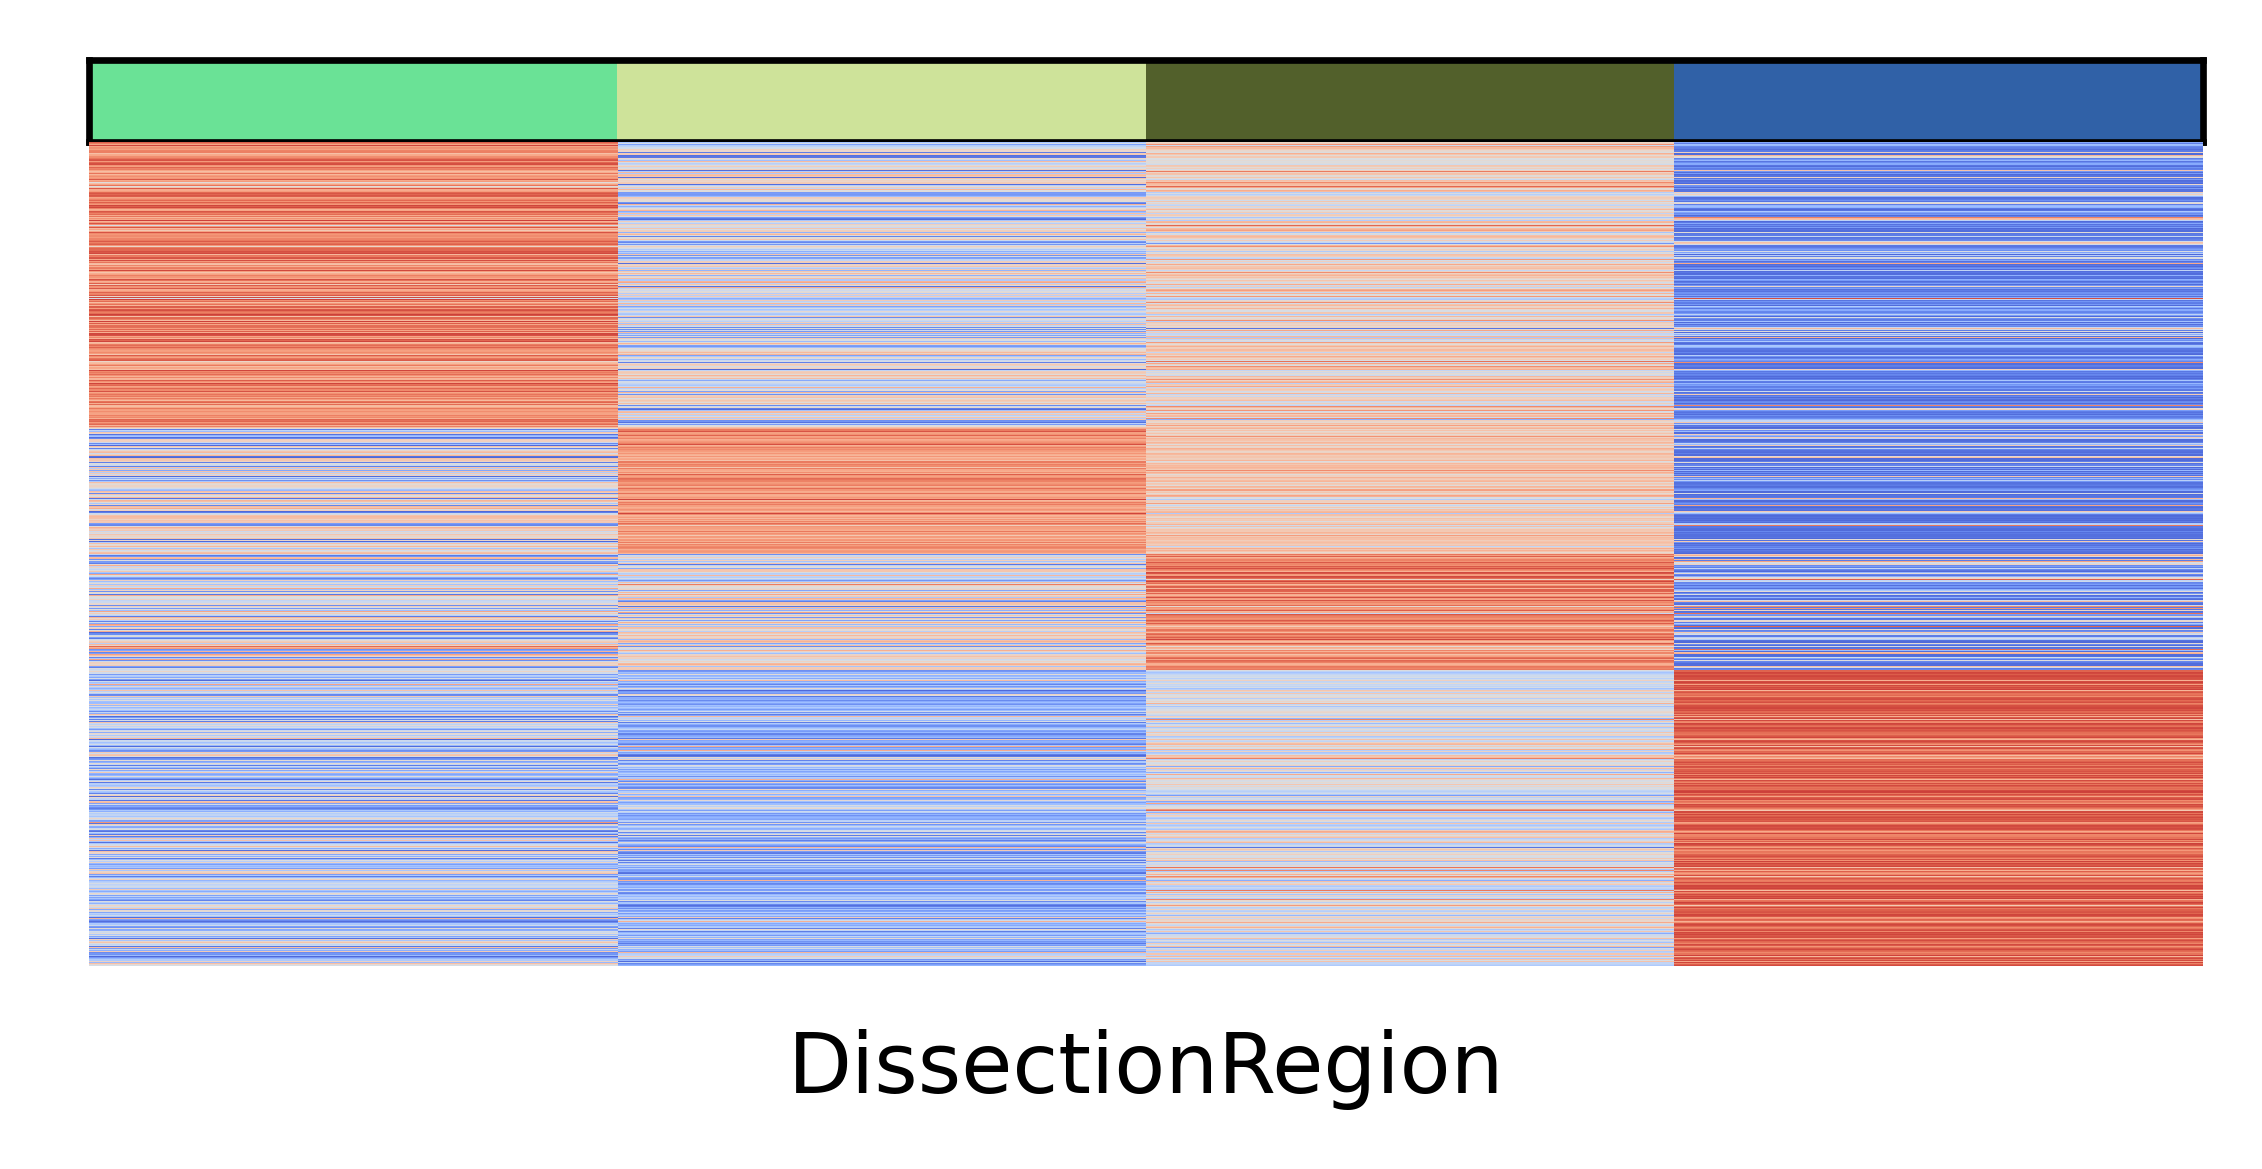

In [26]:
fig = plt.figure(figsize=(5, 2), dpi=600)
gs = fig.add_gridspec(
    2,2,  height_ratios=(1, 10), width_ratios=(1, 10), hspace=0, wspace=0
)

ax = fig.add_subplot(gs[0, 1])
ax.imshow(region_colors[None, :, :], aspect="auto")
ax.set(xticks=[], yticks=[], ylabel="", xlabel="")


ax = fig.add_subplot(gs[1,1])
kwargs = {'rasterized':True}

sns.heatmap(data = to_plot,
            ax = ax,
            vmin=-2,
            cbar=None,
            vmax=2,
            cmap='coolwarm_r',
            xticklabels=False,
            yticklabels=False,
            **kwargs
           )

fig.savefig(f'{region_axis}.GLUT.{var}.DMG.pdf',bbox_inches = 'tight')

## GO to check

In [27]:
# from gseapy import barplot, dotplot
# from gseapy.plot import gseaplot
# import gseapy as gp

In [28]:
# go_mf = gp.get_library(name='GO_Biological_Process_2021', organism='Mouse')

In [29]:
# all_regions = list(balanced_subregion_dmgs.keys())
# _region = all_regions[0]
# _region

In [30]:
# interested_genes = subregion_dmgs[f'{_region}']
# gene_list_new = [gene.upper() for gene in interested_genes]

In [31]:
# enr2 = gp.enrich(gene_list=gene_list_new, 
#                  gene_sets=go_mf,
#                  outdir=None,
#                  verbose=False)
# enr2.res2d.sort_values('Adjusted P-value').head()

In [32]:
# ax = barplot(enr2.res2d,
#              title=f"{_region} DMG", 
#              figsize=(4, 5), 
#              color='darkred',
#              #ofname = 'HignE_GO.png'
#             )